In [8]:
import numpy as np
np.set_printoptions(linewidth=200, precision=4) # to print wide matrices

import simphony
simphony.Config.set_platform('gpu')
simphony.Config.set_matplotlib_format('retina')

from matplotlib import pyplot as plt
from scipy.stats import bootstrap
from scipy.optimize import curve_fit

In [16]:
plt.rcParams.update({'font.size': 14})

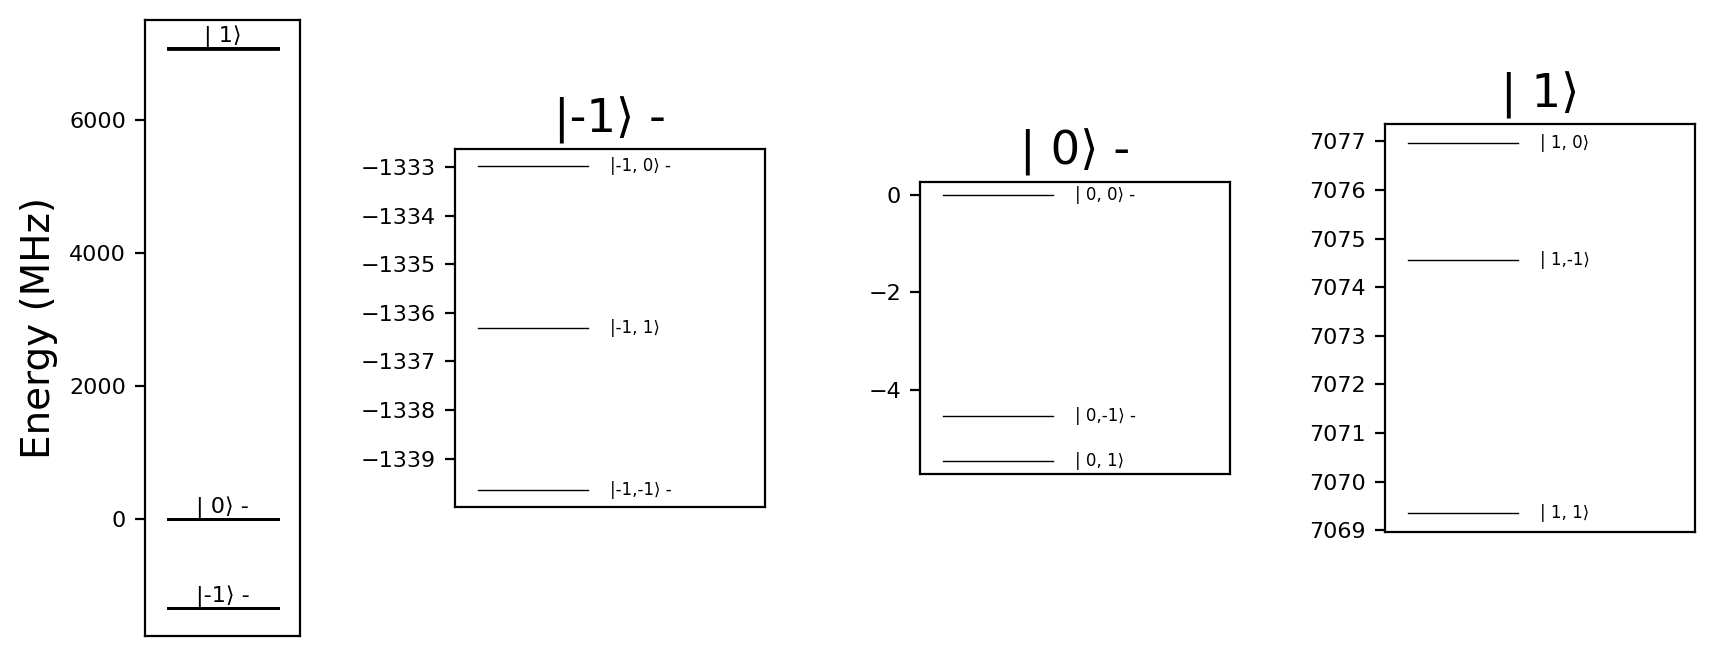

In [11]:
model = simphony.default_nv_model(nitrogen_isotope=14,
                                  static_field_strength=15e-2)
model.plot_levels()

In [12]:
model.spin('e').local_quasistatic_noise.z = 0.3# MHz

In [13]:
def CPMG(model, wait, n, apply_noise=False, n_shots=1):
    
    duration = 0.01
    
    frequency = model.splitting_qubit('e', rest_quantum_nums={'N': 0})
    
    angle1 = np.pi / 2
    period_time1 = 2 * np.pi * duration / angle1
    angle2 = np.pi
    period_time2 = 2*np.pi*duration/angle2
    amplitude1 = model.rabi_cycle_amplitude_qubit(driving_field_name='MW_x',
                                                 period_time=period_time1,
                                                 spin_name='e')
    amplitude2 = model.rabi_cycle_amplitude_qubit(driving_field_name='MW_x',
                                                 period_time=period_time2,
                                                 spin_name='e')

    model.remove_all_pulses()
    model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude1,
                                                    frequency=frequency,
                                                    phase=0,
                                                    duration=duration)
    for i in range(n):
        model.driving_field('MW_x').add_wait(wait)
        model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude2,
                                                    frequency=frequency,
                                                    phase=np.pi/2,
                                                    duration=duration)
        if i !=n-1:
            model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude1,
                                                    frequency=frequency,
                                                    phase=np.pi,
                                                    duration=duration)

    result = model.simulate_time_evolution(n_eval=5, apply_noise=apply_noise, n_shots=n_shots)
    
    result.initial_state = model.productstate({'e': 0, 'N': 0})
    expectation_value = result.expectation_value('ZI', t_idx=-1, shot='all', frame='lab')
    
    return expectation_value[:,0,0]

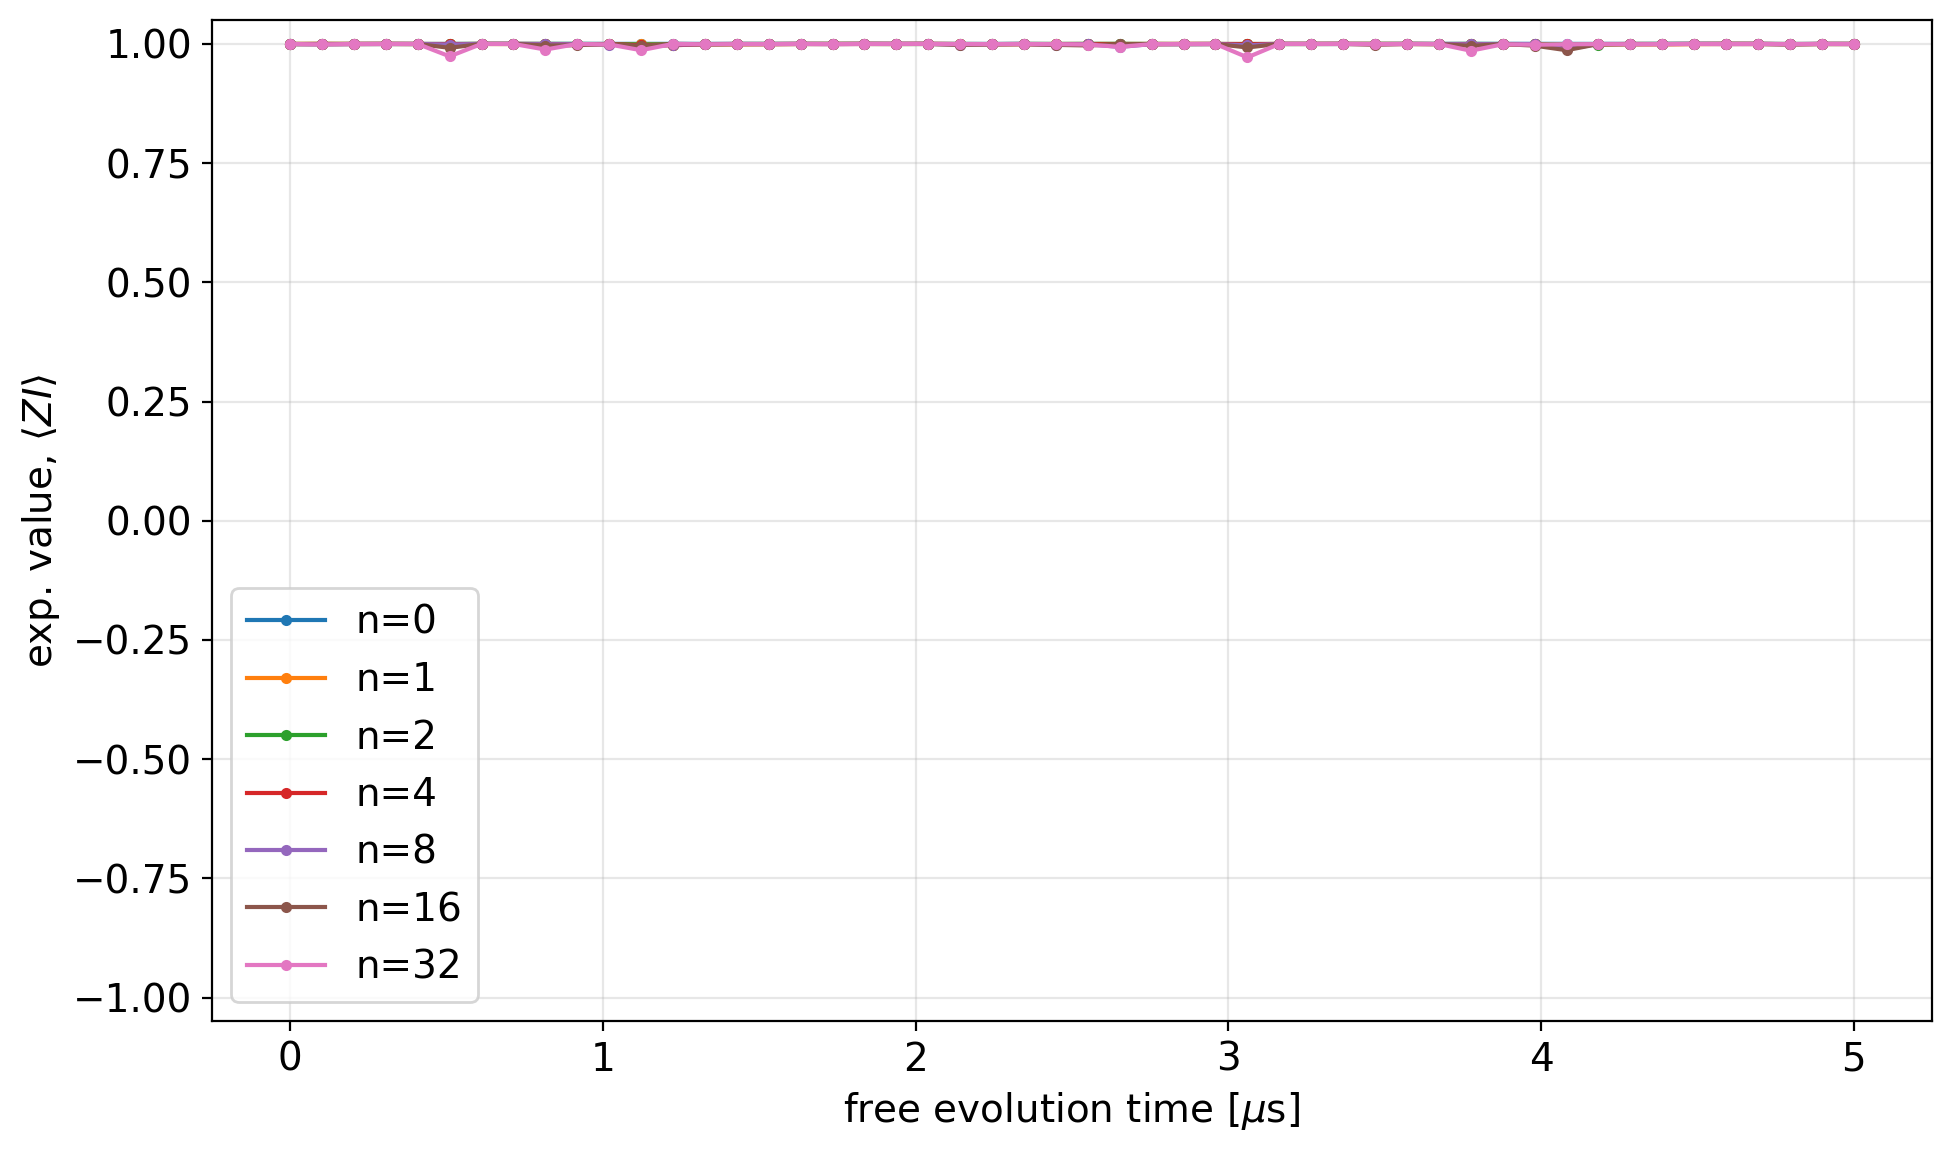

In [ ]:
waits = np.linspace(1e-5, 5, 50)
n_values = [0,1, 2, 4, 8, 16, 32]  

Z_exps_grid = np.zeros((len(n_values), len(waits)))

for i, n in enumerate(n_values):
    for j, wait in enumerate(waits):
        Z_exp = CPMG(model=model, wait=wait, n=n)
        Z_exps_grid[i, j] = Z_exp.item() if hasattr(Z_exp, 'item') else Z_exp[0]

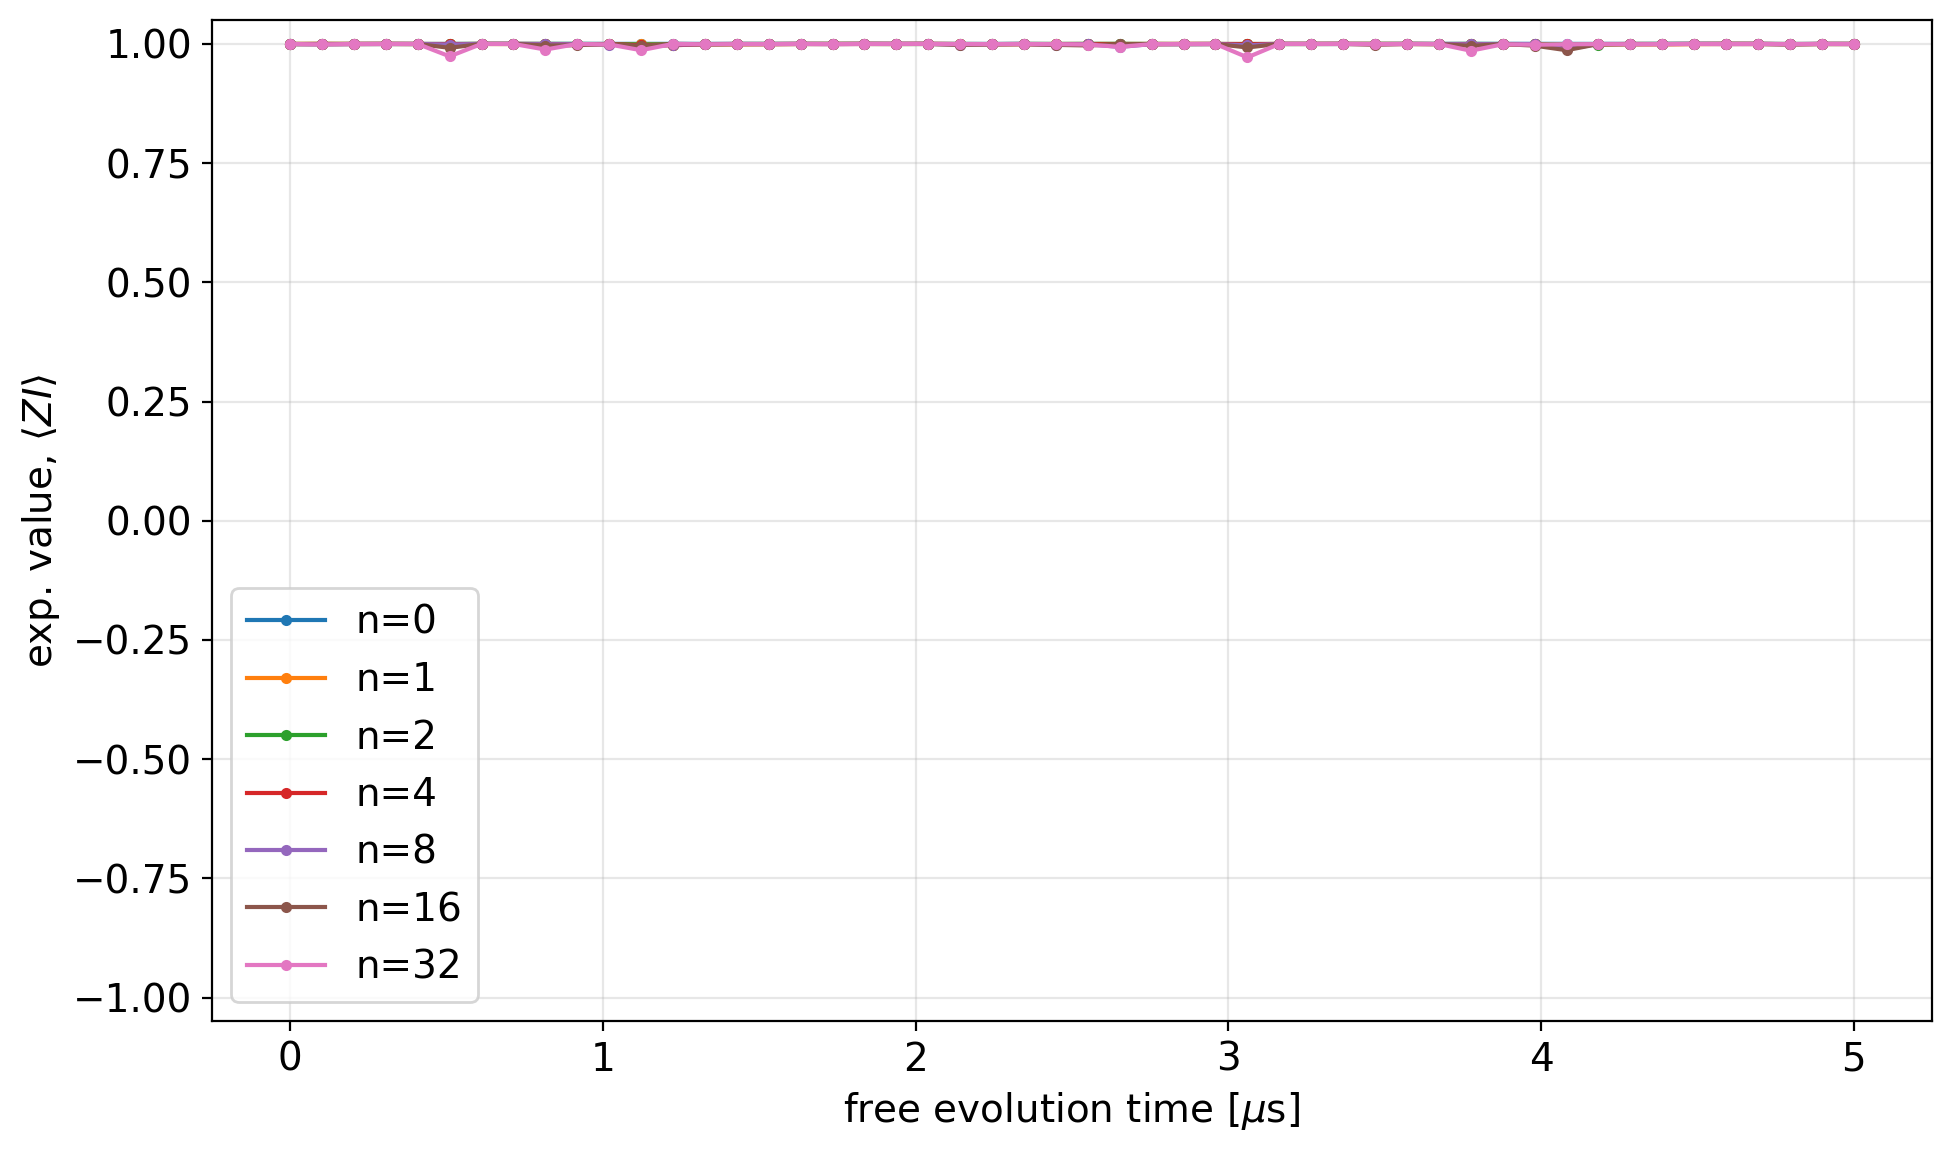

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, n in enumerate(n_values):
    ax.plot(waits, Z_exps_grid[i], 'o-', label=f'n={n}', markersize=3)

ax.set_xlabel('free evolution time [$\mu$s]')
ax.set_ylabel('exp. value, $\\langle ZI \\rangle$')
ax.set_ylim(-1.05, 1.05)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Check.pdf")

In [22]:
waits = np.linspace(1e-5, 30, 30)
n_values = [0, 1, 2, 4, 8]  
n_shots = 128

Z_exps_dict = {}

for n in n_values:
    Z_exps = []
    for idx, wait in enumerate(waits):
        Z_exp = CPMG(model=model, wait=wait, n=n, apply_noise=True, n_shots=n_shots)
        Z_exps.append(Z_exp)
    Z_exps_dict[n] = np.array(Z_exps)
    

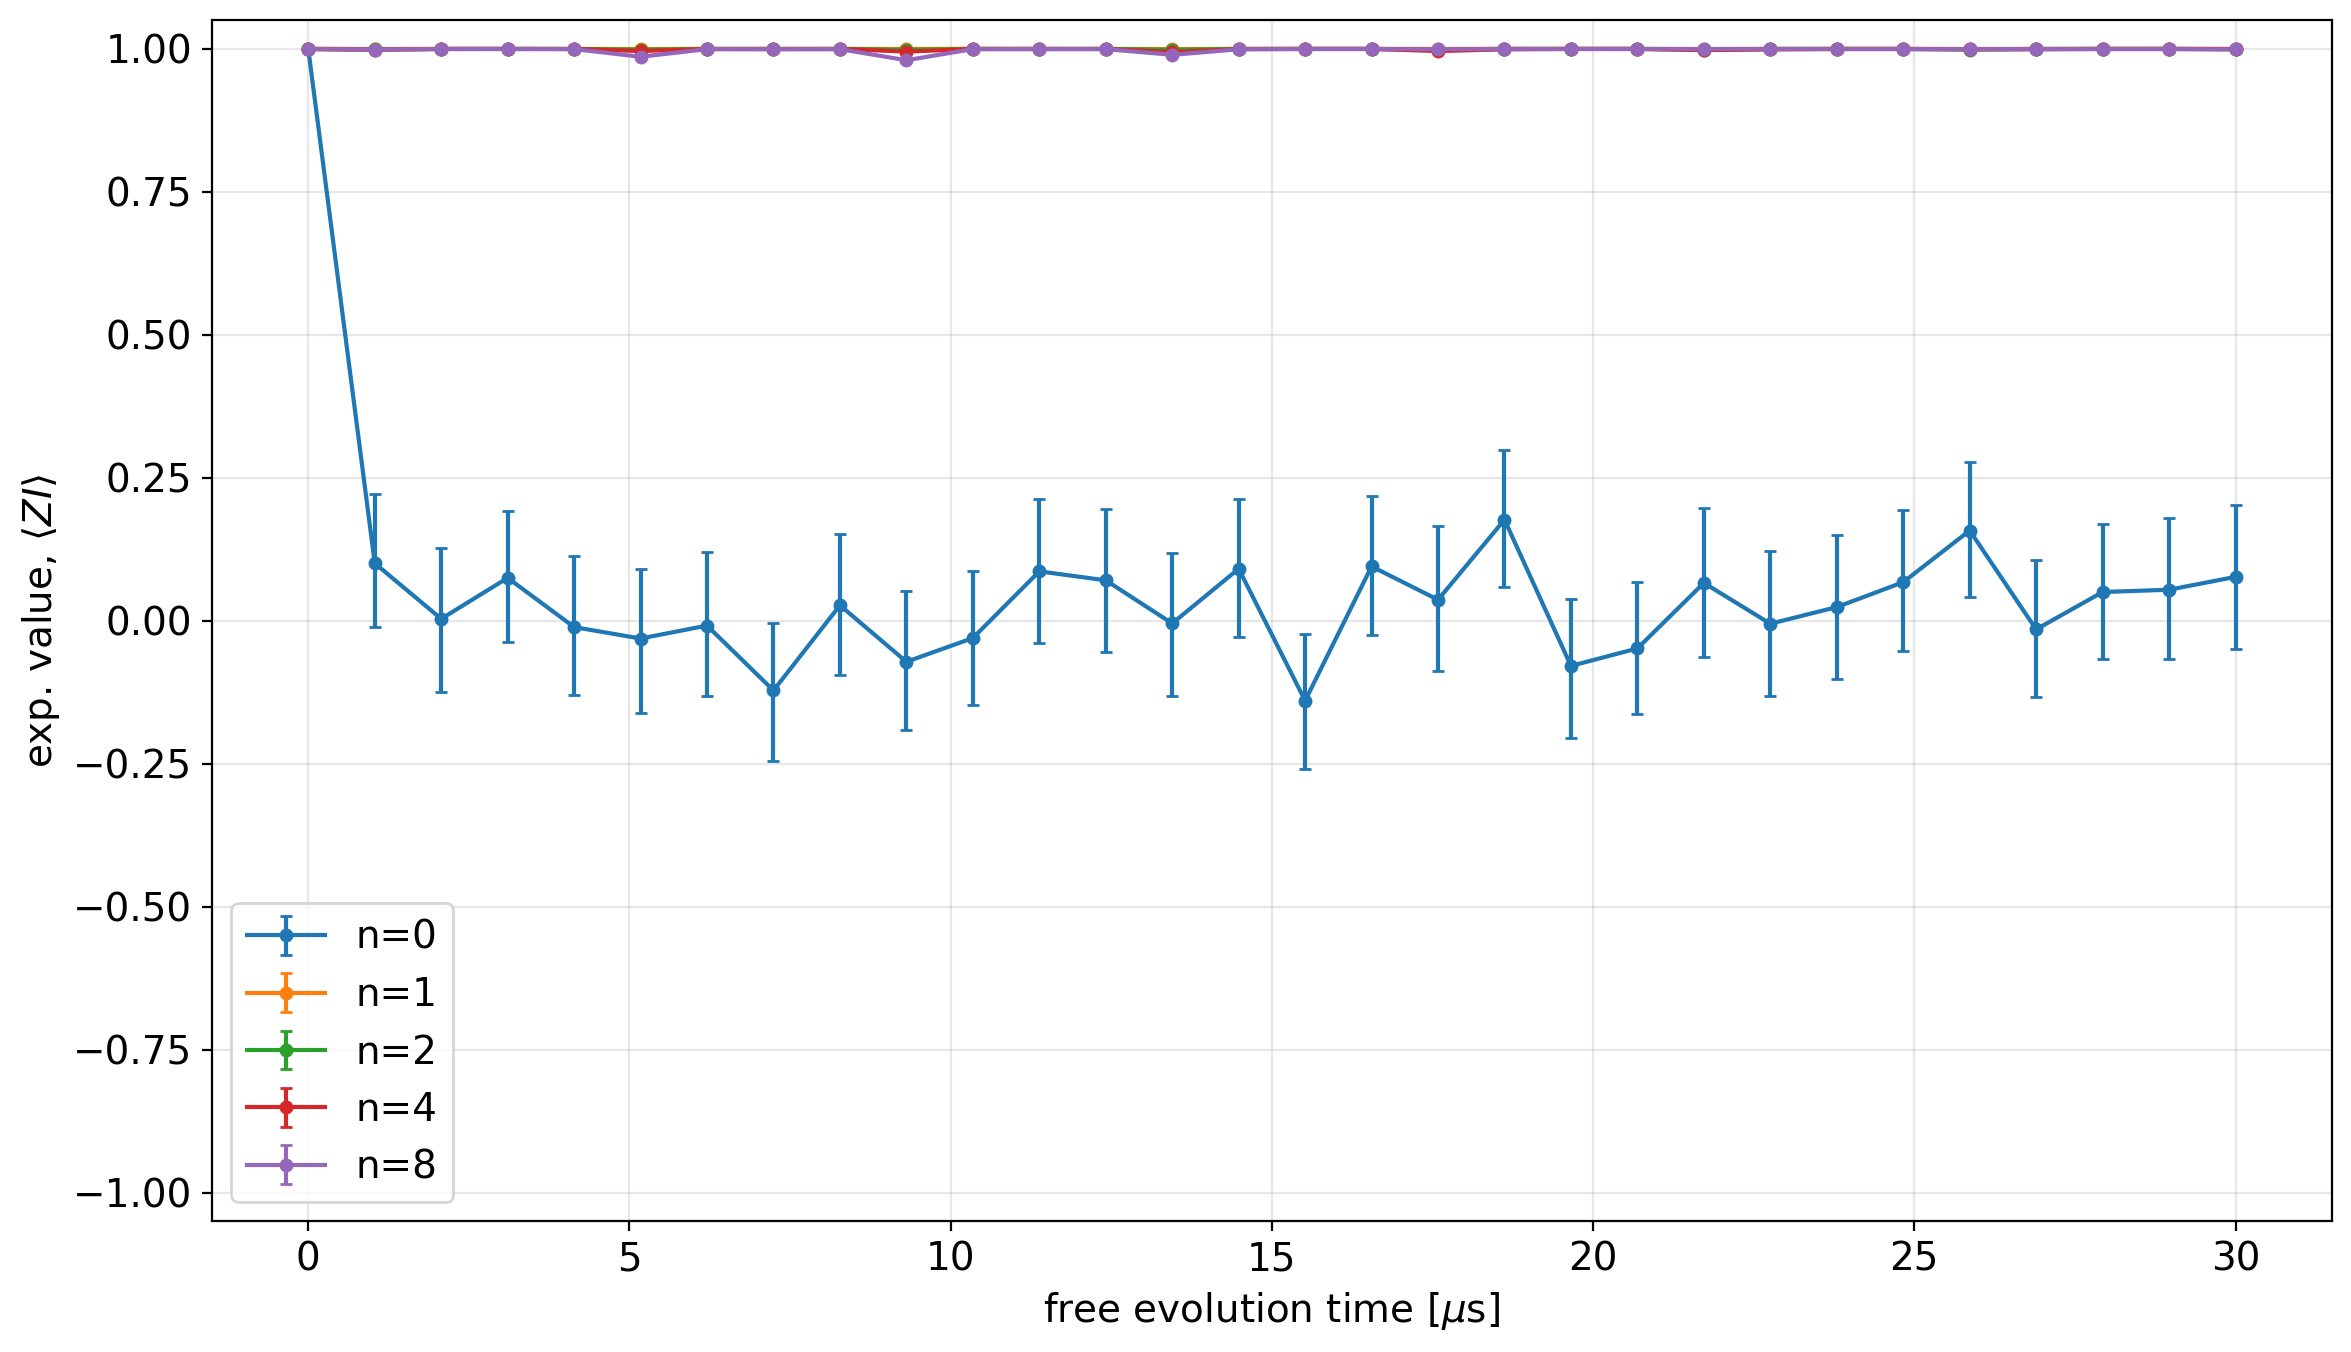

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

Z_exps_stats = {}

for n in n_values:
    Z_exps = Z_exps_dict[n]
    
    nan_mask = ~np.isnan(Z_exps).any(axis=1)
    Z_exps_filtered = Z_exps[nan_mask]
    waits_filtered = waits[nan_mask]
    
    if len(Z_exps_filtered) == 0:
        continue    
    Z_exps_bootstaped = bootstrap((Z_exps_filtered,), lambda x, axis: np.mean(x, axis=axis), 
                                   vectorized=True, axis=1)
    
    Z_exps_mean = np.mean(Z_exps_filtered, axis=1)
    Z_exps_low = Z_exps_bootstaped.confidence_interval.low
    Z_exps_high = Z_exps_bootstaped.confidence_interval.high
    Z_exps_err = [Z_exps_high - Z_exps_mean, Z_exps_mean - Z_exps_low]
    
    Z_exps_stats[n] = {
        'mean': Z_exps_mean,
        'err': Z_exps_err,
        'waits': waits_filtered
    }
    
    ax.errorbar(waits_filtered, Z_exps_mean, yerr=Z_exps_err, capsize=2, 
                label=f'n={n}', marker='o', markersize=4)

ax.set_xlabel('free evolution time [$\mu$s]')
ax.set_ylabel('exp. value, $\\langle ZI \\rangle$')
ax.set_ylim(-1.05, 1.05)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("T2.pdf")

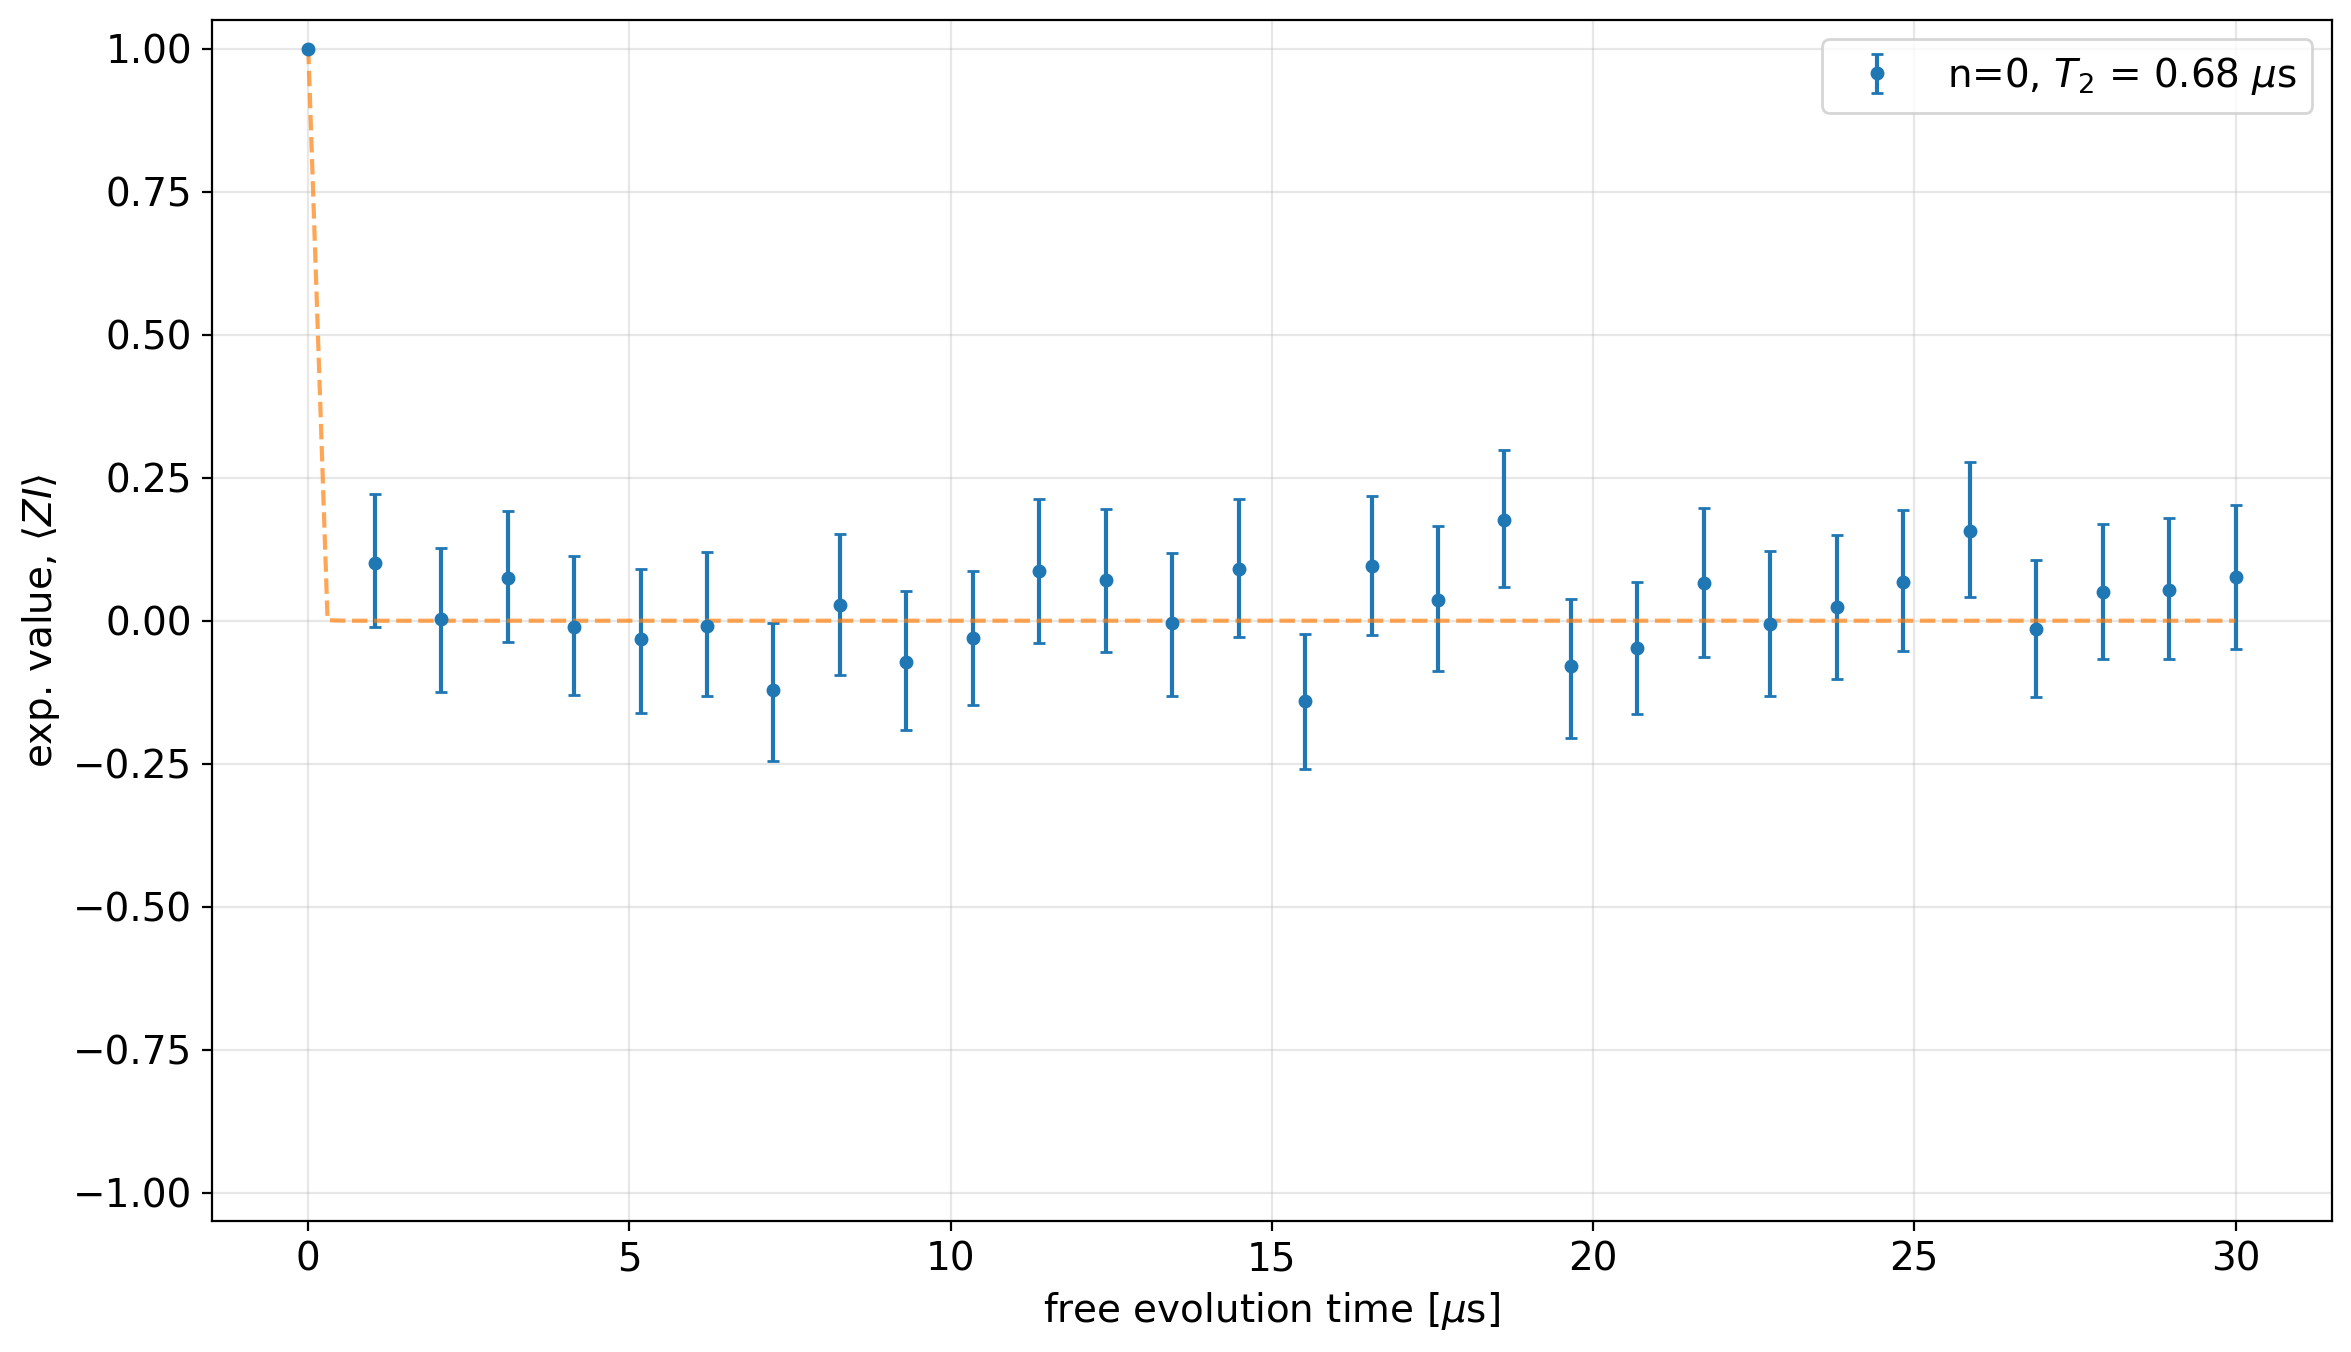

In [25]:
def func(tau, t2, n):
    if n==0:
        return np.exp(-(tau/t2)**2)
    else:
        return np.exp(- 2*n * tau / t2)
fig, ax = plt.subplots(figsize=(12, 7))

T2_values = []

    
Z_exps_mean = Z_exps_stats[0]['mean']
Z_exps_err = Z_exps_stats[0]['err']
waits_filtered = Z_exps_stats[0]['waits']

func_fixed_n = lambda tau, t2: func(tau, t2, 0)

popt, pcov = curve_fit(func_fixed_n, waits_filtered, Z_exps_mean)
T2_values.append((n, popt[0], np.sqrt(pcov[0, 0])))

waits2 = np.linspace(waits_filtered[0], waits_filtered[-1], 101)
Z_exps_mean_fit = [func(t, popt[0], n) for t in waits2]

ax.errorbar(waits_filtered, Z_exps_mean, yerr=Z_exps_err, capsize=2, 
            label=f'n={0}, $T_2$ = {popt[0]:.2f} $\mu$s', 
            marker='o', markersize=4, linestyle='')
ax.plot(waits2, Z_exps_mean_fit, linestyle='--', alpha=0.7)
ax.set_xlabel('free evolution time [$\mu$s]')
ax.set_ylabel('exp. value, $\\langle ZI \\rangle$')
ax.set_ylim(-1.05, 1.05)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Ramsey.pdf")